In [13]:
import numpy as np
from scipy.stats import gamma
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.special import expit

In [14]:
# Sodium activation
def gating_m(v):
    r = -40.0
    k = 9.0
    Vmax = -38.0
    std = 30.0
    Camp = 0.46
    Cbase = 0.04
    tau = Cbase + Camp * np.exp(-((v - Vmax) ** 2) / (std ** 2))
    sigma = expit((v - r) / k)

    return tau, sigma

# Sodium inactivation
def gating_h(v):
    r = -62.0
    k = -7.0
    Vmax = -67.0
    std = 20.0
    Camp = 7.4
    Cbase = 1.2
    tau = Cbase + Camp * np.exp(-((v - Vmax) ** 2) / (std ** 2))
    sigma = expit((v - r) / k)
    return tau, sigma

# Potassium activation
def gating_n(v):
    r = -53.0
    k = 15.0
    Vmax = -79.0
    std = 50.0
    Camp = 4.7
    Cbase = 1.1
    tau = Cbase + Camp * np.exp(-((v - Vmax) ** 2) / (std ** 2))
    sigma = expit((v - r) / k)
    return tau, sigma

# HH ODE function
def HH_ode(t, z, Iapp_func, c, g_tuple, E_tuple):
    v, m, h, n = z
    gNa, gK, gL = g_tuple
    ENa, EK, EL = E_tuple

    tau_m, sigma_m = gating_m(v)
    tau_h, sigma_h = gating_h(v)
    tau_n, sigma_n = gating_n(v)

    INa = gNa * (m ** 3) * h * (v - ENa)
    IK = gK * (n ** 4) * (v - EK)
    IL = gL * (v - EL)

    dvdt = (Iapp_func(t) - INa - IK - IL) / c
    dmdt = (sigma_m - m) / tau_m
    dhdt = (sigma_h - h) / tau_h
    dndt = (sigma_n - n) / tau_n

    return [dvdt, dmdt, dhdt, dndt]
    

# Parameters
c = 1.0

gNa = 120.0
gK = 36.0
gL = 0.3
g = (gNa, gK, gL)

ENa = 55.0
EK = -77.0
EL= -54.4
E = (55.0, -77.0, -54.4)

dt = 0.1
Tfinal = 100.
t_span = (0.0, Tfinal)

# Define bump function for input
alpha = 2.
tau = 5.
γ = lambda t: gamma.pdf(t, a=alpha, scale=tau)

# Define input
I0 = 0.0
alpha1 = 15.; t1 = 10.;
alpha2 = 25.; t2 = t1 + 40.;
Iapp = lambda t: I0 + alpha1 * γ(t - t1) + alpha2 * γ(t - t2)


# Initial conditions
v0 = -64.0
m0, h0, n0 = 1 / (1 + np.exp(-(v0 + 40) / 9)), 1 / (1 + np.exp(-(v0 + 62) / -7)), 1 / (1 + np.exp(-(v0 + 53) / 15))
z0 = [v0, m0, h0, n0]


In [15]:
# Solve the ODE for y
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

soly = solve_ivp(lambda t, z: HH_ode(t, z, Iapp, c, g, E),t_span, z0, t_eval=t_eval, method='RK45',dense_output=True, max_step=dt)


In [ ]:
dg = 0.1
gNagrid = np.arange(106,125,dg)
solx =[]
for gnaval in gNagrid:
    solx.append(solve_ivp(lambda t, z: HH_ode(t, z, Iapp, c, (gnaval, gK, gL), E),t_span, z0, t_eval=t_eval, method='RK45',dense_output=True, max_step=dt))


In [17]:
# Parameters for backpass where we set gk = 100

gNa = 120.0
gK = 100.0
gL = 0.3
g = (gNa, gK, gL) # gNa, gK, gL

In [18]:
## Helper functions for linearisation
def tau_prime_m(v):
    Vmax = -38.0
    std = 30.0
    Camp = 0.46
    return -(2*Camp*(v-Vmax)*np.exp(-(v-Vmax)**2/std**2))/std**2

def sigma_prime_m(v):
    r = -40.0
    k = 9.0
    s = expit((v - r) / k)
    return s * (1 - s) / k

def tau_prime_h(v):
    Vmax = -67.0
    std = 20.0
    Camp = 7.4
    return -(2*Camp*(v-Vmax)*np.exp(-(v-Vmax)**2/std**2))/std**2

def sigma_prime_h(v):
    r = -62.0
    k = -7.0
    s = expit((v - r) / k)
    return s * (1 - s) / k

def tau_prime_n(v):
    Vmax = -79.0
    std = 50.0
    Camp = 4.7
    return -(2*Camp*(v-Vmax)*np.exp(-(v-Vmax)**2/std**2))/std**2

def sigma_prime_n(v):
    r = -53.0
    k = 15.0
    s = expit((v - r) / k)
    return s * (1 - s) / k


In [19]:
## Jacobian computation
def compute_jacobian(v, m, h, n,gNa,gK):
    # Precompute gating variables and their derivatives
    tau_m, sigma_m = gating_m(v)
    tau_h, sigma_h = gating_h(v)
    tau_n, sigma_n = gating_n(v)

    tau_prime_m_val = tau_prime_m(v)
    sigma_prime_m_val = sigma_prime_m(v)
    tau_prime_h_val = tau_prime_h(v)
    sigma_prime_h_val = sigma_prime_h(v)
    tau_prime_n_val = tau_prime_n(v)
    sigma_prime_n_val = sigma_prime_n(v)

    # Precompute reusable terms
    tau_m_sq = tau_m ** 2
    tau_h_sq = tau_h ** 2
    tau_n_sq = tau_n ** 2

    gating_m_term = (sigma_prime_m_val * tau_m - tau_prime_m_val * (sigma_m-m)) / tau_m_sq
    gating_h_term = (sigma_prime_h_val * tau_h - tau_prime_h_val * (sigma_h-h)) / tau_h_sq
    gating_n_term = (sigma_prime_n_val * tau_n - tau_prime_n_val * (sigma_n-n)) / tau_n_sq
    # Construct the Jacobian matrix
    A = np.array([
        [(-gNa * (m ** 3) * h - gK * (n ** 4) - gL)/ c,  (-gNa * h * 3 * (m ** 2) * (v - ENa))/ c,  (-gNa * (m ** 3) * (v - ENa))/ c,  (-gK * 4 * (n ** 3) * (v - EK))/ c],
        [gating_m_term, -1.0 / tau_m, 0, 0],
        [gating_h_term, 0, -1.0/ tau_h, 0],
        [gating_n_term, 0, 0, -1.0 / tau_n],
    ])
    return A

def compute_fmu(v, m, h,n):
    return np.array([
        -(m**3)*h*(v - ENa)/c,
        0.0,
        0.0,
        0.0,
    ])



In [20]:
# Cost and output definitions
C = np.zeros((4,4))
C[0][0]=1

def costs(x, y, T):
    e = (C @ x)[0] - y
    return 0.5 * e**2 / T

def costsprime(x, y, T,C):
    e = C @ x - y           # error vector
    return (C.T @ e) / T


# Terminal cost gradient phi_x (here zero)
def phi_x(xT):
    return 0

In [21]:
def backpass_lambda(t, lam, sol_x,sol_y,gNaval, T, C):
    x = sol_x.sol(t)
    v, m, h, n = x
    y = sol_y.sol(t)[0]   

    lamx = lam[0:4]
    lammu = lam[-1]

    Fx = compute_jacobian(v,m,h,n,gNaval,100) # nb here is where we set gk=100
    Fmu = compute_fmu(v,m,h,n)

    l_x = costsprime(x[:4], y, T, C)
   
    dlamx_dt = - l_x - Fx.T @ lamx 
    dlamu_dt = - (Fmu.T @ lamx)

    return np.concatenate([dlamx_dt, [dlamu_dt]])


In [22]:
sol_lambda = []
lambda_traj=[]
for gnaidx, gnaval in enumerate(gNagrid):
    sol_lambda.append(solve_ivp(
        fun=lambda t, lam: backpass_lambda(t, lam, solx[gnaidx],soly, gnaval,Tfinal,C),
        t_span=(t_span[1], t_span[0]),  # Backward integration
        y0=np.zeros(5),
        t_eval=t_eval[::-1],            # Evaluate from T to 0
        method='RK45',
        max_step=dt,
        #dense_output=True
    ))
    # # Reverse the solution to match forward time
    lambda_traj.append(sol_lambda[gnaidx].y[:, ::-1])  # Now shape (4, len(t_eval)), time increasing


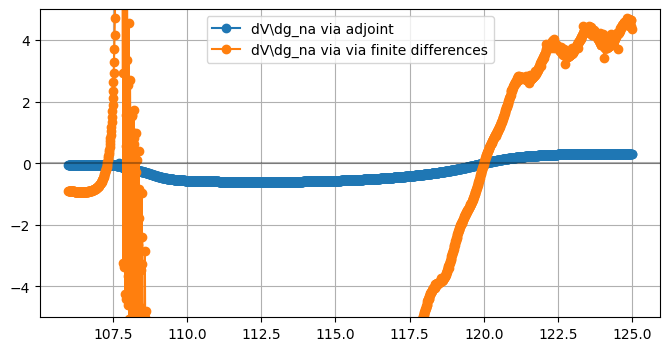

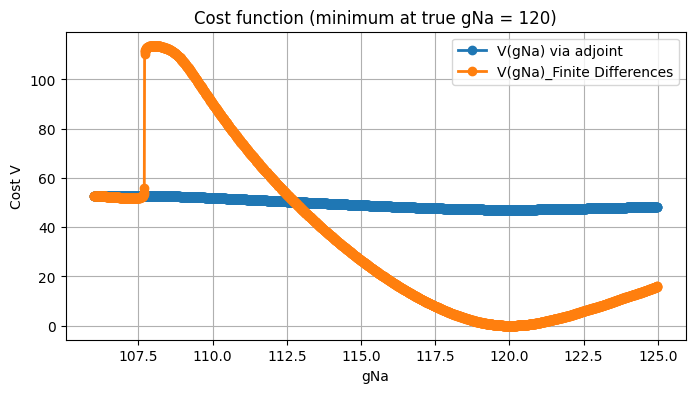

In [23]:


def compute_cost(sol_model, sol_true, T):
    e = sol_model.y[0] - sol_true.y[0]
    return 0.5 * np.trapezoid(e**2, sol_model.t) / T

V = np.array([
    compute_cost(solx[i], soly, Tfinal)
    for i in range(len(gNagrid))
])


g_mid = gNagrid[:-1]#0.5 * (gNagrid[:-1] + gNagrid[1:])

gfd = np.diff(V)/ dg
gad = np.array([
    lambda_traj[gnaidx][4][0]
    for gnaidx in range(len(gNagrid))
])  


plt.figure(figsize=(8,4))
plt.plot(gNagrid, gad, 'o-', label='dV\dg_na via adjoint')
plt.plot(g_mid, gfd, 'o-', label='dV\dg_na via via finite differences')
plt.ylim(-5, 5)
plt.axhline(0, color='k', alpha=0.3)
plt.legend()
plt.grid()
plt.show()

Vgad = V[0] + np.concatenate([[0], np.cumsum((gad[:-1] + gad[1:])/2) * dg])
# V[0] + np.cumsum(gad)*dg

plt.figure(figsize=(8,4))
plt.plot( gNagrid,Vgad, 'o-', lw=2, label='V(gNa) via adjoint' )
plt.plot(gNagrid, V, 'o-', lw=2, label='V(gNa)_Finite Differences' )
#plt.ylim(-5, 5)
#plt.axvline(120, color='r', ls='--', alpha=0.6, label='gNa true')
plt.xlabel('gNa')
plt.ylabel('Cost V')
plt.title('Cost function (minimum at true gNa = 120)')
plt.legend()
plt.grid()
plt.show()



In [24]:
# # write data for pgfplots: columns named "gNagrid", "Vgad", "V"
# import os
# out_path = "/home/jpk/Desktop/Queues/SurrogateGradients/firstExampleSingleNeuronCostFunctionData.dat"
# data = np.column_stack((gNagrid, Vgad, V))
# header = "gNagrid Vgad V"

# np.savetxt(out_path, data, fmt="%.6e", header=header, comments="")
# print(f"Wrote {data.shape[0]} rows to {out_path}")


# out_path = "/home/jpk/Desktop/Queues/SurrogateGradients/firstExampleSingleNeuronCostFunctionGradientData.dat"
# data = np.column_stack((gNagrid[:-1], gad[:-1], g_mid, gfd))
# header = "gNagrid gad gnamid gfd"
# np.savetxt(out_path, data, fmt="%.6e", header=header, comments="")
# print(f"Wrote {data.shape[0]} rows to {out_path}")
